# Different trends in Difference in Difference: Interactive Fixed Effects. Exploration of Gobillon and Magnac (2016)

In various economic scenarios, there may be a need to evaluate the effect of a policy across distinct groups. A challenge commonly encountered in these cases is that the mechanism for policy assignment is usually non-random, rendering basic mean comparisons across groups insufficient for revealing causal effects. A potential solution lies in utilizing more comprehensive datasets, which possess a temporal aspect. The underlying rationale here is that despite the policy assignment not being random, the changes occurring over time could be. This logic forms the basis of the widely-used Difference-in-Difference (DID) research design. 

The DID design compares the variation in outcomes between units that were impacted by the policy (referred to as treated units) and those that weren't (referred to as untreated units), both prior to and following the implementation of the policy (treatment assignment). This method fundamentally relies on the "common trend assumption." This assumption suggests that in the absence of treatment assignment, the changes in outcomes for both the treated and untreated units would have been the same size. 

The common trend assumption is suggestive of a Data Generating Process (DGP) in the given form. Here, we denote $\alpha_{i}$ as the individual fixed effect and $\gamma_t$ as the time fixed effect. We use $D_{i,t}$ as an indicator showing whether unit $i$ is treated during period $t$. As such, we have:

\begin{equation}
Y_{i,t} = \alpha_{i} + \gamma_{t} + \alpha D_{i,t}  + \epsilon_{i,t}, \quad  \epsilon_{i,t} \sim N(0,1)
\end{equation}

where $\alpha_{i}$ and $\gamma_{t}$ are unit and time fixed effects and $\epsilon_{i,t}$ is a random error term. While the Difference-in-Difference (DID) approach is extensively used, the common trend assumption can be overly restrictive in certain scenarios. In many cases it might be more reasonable to assume that temporal trends are influenced by common factors that affect both treated and untreated units. Subsequently, we will examine how introducing these factors influences our DID estimator and how the Factor-DID estimator, as proposed in Gobillon and Magnac, 2016, might help us estimating causal effect, even when the standard common trend assumption fails.

Let's consider the following Data Generating Process (DGP)

\begin{align*}
Y_{i,t} &= \alpha D_{i,t} + \beta x_{i,t} + f_t' \mu_i  +  \gamma_t + \lambda_i + u_{i,t} \\
f_{t} &= 0.9f_{t-1} + \epsilon_{f,t} \\
x_{i,t} &\sim N(0,1)
\end{align*}

where $\gamma_t$, $\lambda_i$, are unit and time fixed effect, $\epsilon_{f,t}$, and $u_{i,t}$ are drawn from a standard normal distribution. We also set $f_0 = \vec{1}$, $\beta = 1$, and $\alpha = 5$. $D_{i,t}$ is an indicator variable that demonstrates whether unit $i$ has received the treatment during period $t$. $f_t$ represents the factors and is a vector of size $L = 3$, and $\mu_i$ is the individual loading effect, and is also a vector of size $L = 3$; for each component $j$, $\mu_{i,j} \sim N(0,1)$. Our parameter of interest is $\alpha$, which captures the causal effect of receiving the treatment. As we'll explore below the common trend assumption is possibly violated here if the treated and non treated group have different distribution of factor loadings. 




The function below generates the data for the above DGP. We will use this function to generate the data for our simulation.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


In [17]:

def genData(N = 143, T=20, T0=8, N0 = 13, nbf=2, constant = 1 , alphaT=0.3, alphaC = 5, selection='random',correlated_errors = 0):
#     print(alphaT)
    fei0 = np.random.normal(size=(N,1))
    fet = np.random.normal(size=(T,1))
    vecL = np.random.uniform(size=(N,nbf))
    vecF = np.zeros((T,nbf))
    
    for t in range(T):
        if t == 0 :
            vecF[t,:] = 1 #np.random.normal(size=(1,nbf))
        if t > 0 :
            vecF[t,:] = 0.9*vecF[t-1,:] + np.random.normal(size=(1,nbf))
            
    if correlated_errors == 0:
        u = np.random.normal(size=(N*T,1))
    if correlated_errors > 0:
        temp_u = np.zeros((N,T))
        temp_u[:,0] = np.random.normal(size=(N,))
        for t in range(1,T):
            temp_u[:,t] = correlated_errors*temp_u[:,t-1] + np.random.normal(size=(N,))
        u = temp_u.reshape(N*T,1)
    
    C = np.random.normal(size=(N*T,1))
    
    if selection == 'random':
        vecD = np.concatenate((np.ones((N0,1)), np.zeros((N-N0,1))),axis=0) 
        vecT = np.concatenate((np.zeros((T0-1,1)), np.ones((T - T0+1,1))),axis=0)
    if selection == 'highValues':
        vecD  = (np.sum(vecL,axis=1) > nbf/2).reshape(-1,1).astype(int)
#         vecD  = ((vecL>0.5).all(axis=1)).reshape(-1,1).astype(int)
        vecT = np.concatenate((np.zeros((T0-1,1)), np.ones((T - T0+1,1))),axis=0)

    X = np.kron(vecD,vecT)
    alphaTb = alphaT*np.ones((N*T,1))

    Y = C*alphaC + X*alphaTb + constant + np.kron(fei0,np.ones((T,1))) + np.kron(np.ones((N,1)),fet) + (vecF@vecL.T).reshape(N*T,1,order='F') + u

    return Y,X,C 



To compute the Factor-DID estimator, we define the following matrices. Let $\hat{L}$ be our estimate for the true number of factors (usually unknown):

- $Y$: an $T \times N$ matrix,
- $X$: an $T \times N$ matrix,
- $D$: an $T \times N$ matrix,
- $F$: a $\hat{L} \times T$ matrix of factors,
- $M$: a $\hat{L} \times N$ matrix of factor loading fixed effects.

To identify the factors, we enforce the restriction that $FF' \frac{1}{T} = I_L$. 

To calculate the Factor-DID estimator, we perform the following steps:

1. Let $\tilde{Y}$ be the demeaned $Y$ matrix. In other words,
$$
(\tilde{Y})_{i,t} = y_{i,t} - \frac{1}{T} \sum_{t \in T} y_{i,t} - \frac{1}{N} \sum_{i \in N} y_{i,t} + \frac{1}{NT} \sum_{t} \sum_i y_{i,t}
$$
Similar definitions apply for $\tilde{X}$ and $\tilde{D}$.

2. Initialize an initial guess for $\hat{F}^0$ and $\hat{M}^0$.

3. For $1 < k < \bar{K}$, we iterate over the following steps:

    a. Given $\hat{F}^{k-1}$ and $\hat{M}^{k-1}$, we solve for $\hat{\beta}^k$ and $\hat{\alpha}$ by regressing $vec(\tilde{Y}) - vec((\hat{F}^{k-1})'\hat{M}^{k-1})$ onto $vec(\tilde{X})$ and $vec(\tilde{D})$ ($vec(X)$ is a function that converts a $T \times N$ matrix into a $TN$-sized vector).
    
    b. To find $\hat{F}^k$, we calculate the eigenvectors of the matrix $ZZ'$, where
    $$
    Z = \tilde{Y} - \tilde{X}\hat{\beta}^k - \tilde{D}\hat{\alpha}^k,
    $$
     and take the eigenvectors corresponding to the highest $\hat{L}$ eigenvalues, multiplied by $\sqrt{T}$.
    
    c. Given $\hat{F}^k$ and $\hat{\beta}^k$, find $\hat{M}^{k}$ by solving
    \begin{align*}
    \hat{M}^{k} = \hat{F}^{k}Z \frac{1}{T}
    \end{align*}
   Note that as we normalized $\frac{1}{T}F'F = I$, this expression is simply a regression of the residualized $Y$s on the factors, aiming to find the factor loadings that minimize  $\sum_T (Y_{i,t} - x_{i,t}\hat{\beta} - \hat{\alpha} D_{i,t} - \mu_{i,t} f_{t})^2$.

4. Set $\bar{K}$ high enough to ensure parameter convergence.

The functions below are used to estimate factor Diff-in-Diff, as just described

In [18]:
def coefC_reg(yp,Cp,CCinverse,Fhat,loadings):
    factors = (Fhat@loadings.T).T.reshape((len(yp),1),order='C')
    betaX = CCinverse@Cp.T@(yp-factors)
    return betaX

def coefCit_reg(ym,yi,yt,c,betac):
    ym = ym - cm*betac
    coefi = yi - ym - ci*betac
    coeft =  yt - ym - ct*betac
    return coefi, coeft, ym

def coefF_reg(yp,N,T,nbf,cp,betac):
    Z = (yp-cp@betac).reshape(T,N,order='F')
    ZT = Z.T
    ZZ = Z@ZT
    evalue, evector = np.linalg.eigh(ZZ)
    ids = evalue.argsort()[-nbf:]
    Fhat = evector[:,list(reversed(ids))] #L times T 
    Fhat = Fhat*np.sqrt(T)    
    Fhat
    if Fhat[0,0]<0:
        Fhat = -Fhat
    return Fhat
    
def coefL_reg(yp,Fhat,N,T,nbf,cp,betac):
    zValue = yp-cp@betac
    Z = zValue.reshape(T,N,order='F')
    Loadings = Fhat.T@Z*(1/T)
    return Loadings.T
    
def coefsbai_reg(y,c,nbf,initL,initF,iter_inner,expl):

    N = initL.shape[0]
    T = initF.shape[0]    
    #Inside the function 
    ym = y.mean()
    yi = y.reshape(T,N,order='F').mean(axis=0)
    yt = y.reshape(T,N,order='F').mean(axis=1)
    yp = y - np.kron(yi[:,np.newaxis],np.ones((T,1))) - np.kron(np.ones((N,1)),yt[:,np.newaxis]) + ym 

    #Derive FE 
    cp = np.zeros(c.shape) 
    for i in range(c.shape[1]):
        temp = c[:,i]
        tempm = temp.mean()
        tempi = temp.reshape(T,N,order='F').mean(axis=0)
        tempt = temp.reshape(T,N,order='F').mean(axis=1)
        tempp = temp[:,np.newaxis] - np.kron(tempi[:,np.newaxis],np.ones((T,1))) - np.kron(np.ones((N,1)),tempt[:,np.newaxis]) + tempm 
        cp[:,i] = tempp[:,0]

    CpCpinverse = np.linalg.inv(cp.T@cp)
    #Get coefficients 
    for iterations in range(100):
        if iterations ==0:
            betac = coefC_reg(yp,cp,CpCpinverse,initF,initL)
        else :
            betac = coefC_reg(yp,cp,CpCpinverse,Fhat,Loadings)
    #     coefi, coeft, ym = coefCit_reg(ym,yi,yt,cm,ci,ct,betac)
        Fhat = coefF_reg(yp,N,T,nbf,cp,betac)
        Loadings = coefL_reg(yp,Fhat,N,T,nbf,cp,betac)

    return betac





We also have a function that caluclates the simple Diff-in-Diff estimator, for comparison

In [19]:
def simpleDID(Y,XD,C,N,T):
    residualized = np.zeros((len(Y),3))
    for k,i in enumerate([Y, XD, C]):
        temp = i
        tempm = temp.mean()
        tempi = temp.reshape(T,N,order='F').mean(axis=0)
        tempt = temp.reshape(T,N,order='F').mean(axis=1)
        tempp = temp - np.kron(tempi[:,np.newaxis],np.ones((T,1))) - np.kron(np.ones((N,1)),tempt[:,np.newaxis]) + tempm 
        residualized[:,k] = tempp[:,0]

    data = np.concatenate((residualized,np.ones((residualized.shape[0],1))),axis=1)
    XX = data[:,1:].T@data[:,1:]
    beta = np.linalg.inv(XX)@data[:,1:].T@data[:,0]
    return beta
    

In [20]:
def dsPlot(x):
    density = gaussian_kde(x)
    a = np.linspace(np.min(x), np.max(x),1000)
    plt.plot(a,density(a));


## Random Selection

We consider a simple setup where units are randomly selected for treatment. Let's denote $N=200$ and $T=20$. Units receive treatment starting from period $10$ and remain treated until the final period. We can define:

$$
D_{i,t} = \mathbb{1}\bigg[i \in \{1,...,25\} \cap t \geq 10\bigg]
$$

This implies that the first 25 units in your panel data receive the treatment. We then proceed to:

1. Generate a sample from the aforementioned DGP, using the random selection rule above.

2. Simulate the DGP for $S = 1000$ iterations. For each simulation:

    a. Estimate $\alpha$ using standard DID.
    
    b. Estimate $\alpha$ using DID-Factor with $\hat{L} = \{2,3,4,5\}$ factors.

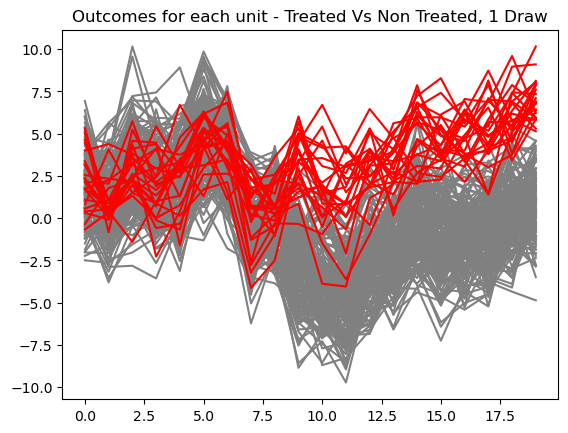

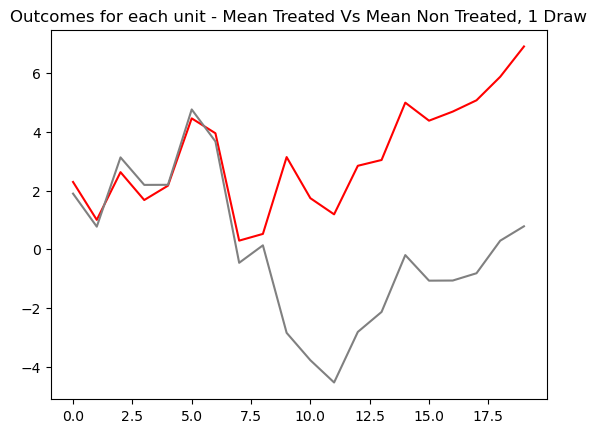

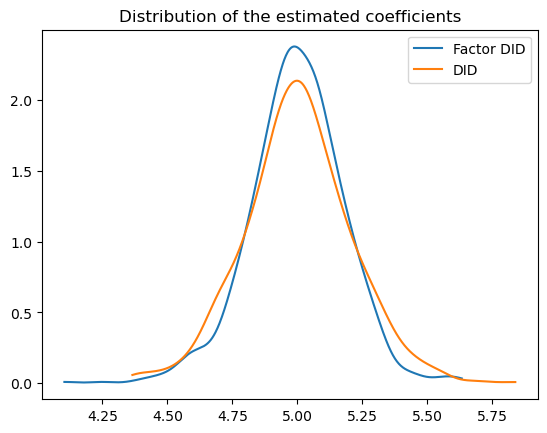

Mean and STD of Factor DID
4.99784634154055 0.18015694609159347
Mean and STD of DID
5.001426397217274 0.2069481840030654


In [21]:
np.random.seed(100)

iter_inner = 20 
S = 1000
N = 200
N0 = 25
T = 20
T0 = 10
nbf = 3
nbfHat =3

Y , X ,C = genData(N = N, T=T, T0=T0, N0 = N0, nbf=nbf, constant = 0 , alphaT=5, alphaC = 1,selection='random',correlated_errors=0)

xMatrix = X.reshape(N,T)
yMatrix = Y.reshape(N,T)
treatedUnits = np.where(np.sum(xMatrix,axis=1)>0)[0]
notTreatedUnits = [i for i in  np.arange(xMatrix.shape[0]) if i not in treatedUnits]
colOrder = list(treatedUnits) + notTreatedUnits
yMatrix = yMatrix[colOrder,:]
treatedUnits = np.where(np.sum(xMatrix,axis=1)>0)[0]

for i in np.arange(yMatrix.shape[0]-1,0,-1):
    if i in treatedUnits:
        plt.plot(yMatrix[i,:].T,color='red');
    else: 
        plt.plot(yMatrix[i,:].T,color='grey');

plt.title('Outcomes for each unit - Treated Vs Non Treated, 1 Draw')
plt.show()

meanTreated = np.mean(yMatrix[:len(treatedUnits),:],axis=0)
meanNotTreated = np.mean(yMatrix[len(treatedUnits):,:],axis=0)
plt.plot(meanTreated,color='red');
plt.plot(meanNotTreated,color='grey');
plt.title('Outcomes for each unit - Mean Treated Vs Mean Non Treated, 1 Draw')
plt.show()

# Simulations
res = np.zeros((S,4))
initL = np.zeros(shape=(N,nbf))
initF = np.zeros(shape=(T,nbf)) 
for i in range(nbf):
    initF[i,i] = np.sqrt(T)


for k in range(S):
    Y , X ,C = genData(N = N, T=T, T0=T0, N0 = N0, nbf=nbf, constant = 0 , alphaT=5, alphaC = 1,selection='random',correlated_errors=0)
    
    D = (np.sum(X.reshape(T,N,order='F'),axis=0)>0).astype(int)
    D = np.kron(D[:,np.newaxis],np.ones((T,1)))
    vecT = np.concatenate((np.zeros((T0-1,1)), np.ones((T - T0+1,1))),axis=0)
    Time = np.kron(np.ones((N,1)),vecT)
    XD = Time*D
    XDC = np.concatenate((XD,C),axis=1)
    
    betaReg = coefsbai_reg(Y,XDC,nbfHat,initL,initF,iter_inner,1)
    betaDID = simpleDID(Y,XD,C,N,T)
    
    res[k,0] = betaReg[0]
    res[k,1] = betaReg[1]
    res[k,2] = betaDID[0]
    res[k,3] = betaDID[1]

    
dsPlot(res[:,0])
dsPlot(res[:,2])
plt.legend(['Factor DID','DID']);
plt.title('Distribution of the estimated coefficients')
plt.show();
print('Mean and STD of Factor DID')
print(np.mean(res[:,0]),np.std(res[:,0]))
print('Mean and STD of DID')
print(np.mean(res[:,2]),np.std(res[:,2]))


As we can see there's no bias in both cases. The random selection implies that the common trend assumption still holds and both the standard DID and the Factor-DID estimators are unbiased. However, the standard DID estimator has slightly higher variance than the Factor-DID estimator. This is because the Factor-DID estimator is able to control for some of the  variation in the data.

## Selection on Factor Loadings 

The common trend assumption may be violated when the units selected for treatment differ systematically from the control units, not only in a constant manner, but also in how they behave over time. In the factor-based setup discussed here, this violation might occur if units are selected for treatment based on their factor loadings. This could lead treated units to interact with and respond differently to population-wide shocks, modeled here as changes in factors.

To explore this, we consider a scenario with $N=200$ units and $T=20$ time periods, with units beginning treatment at period 10 and remaining treated until period $T$. We assume selection based on factor loadings, specifically:
$$
D_{i,t} = \mathbb{I}\bigg[\vec{\mu_i} \vec{1} \geq 1.5 \cap t \geq 10 \bigg]
$$

This implies that only units for which the sum of their loadings exceeds 1.5 receive treatment. We then proceed as follows:

1. Generate a sample from the DGP mentioned above, using the non-random selection rule.

2. Simulate the DGP for $S = 1000$ iterations. In each simulation, compare the standard DID estimator with the Factor-DID estimator.



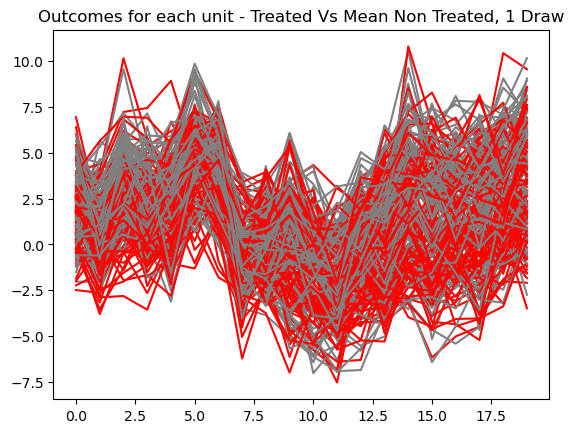

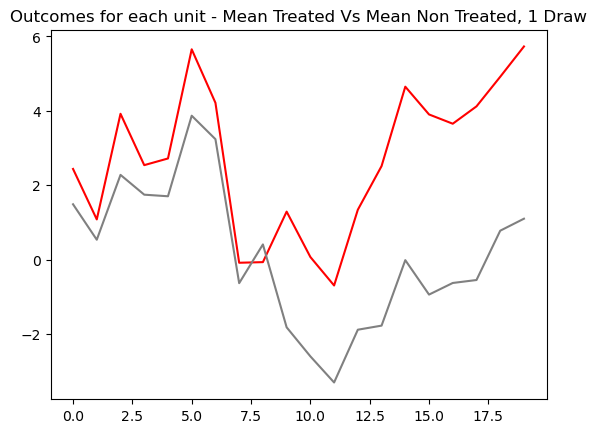

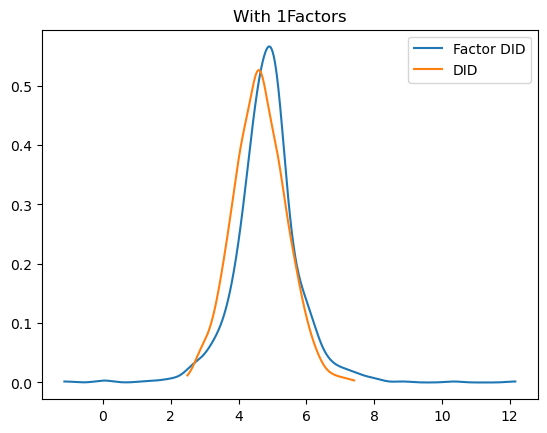

Mean and STD of Factor DID
4.835571982427263 0.9636431674130341
Mean and STD of DID
4.615191260314527 0.7782031255525655


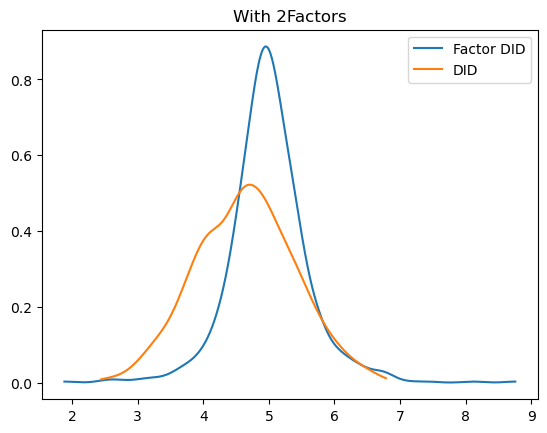

Mean and STD of Factor DID
4.999957340687875 0.597079029529269
Mean and STD of DID
4.645786903038107 0.7567550226935346


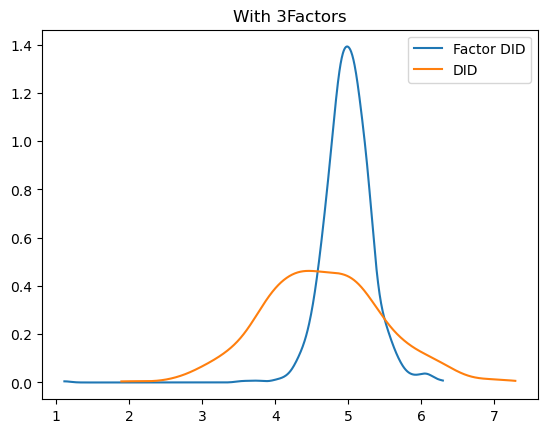

Mean and STD of Factor DID
4.995465779175232 0.33509976452299994
Mean and STD of DID
4.644709223209459 0.8124653201139609


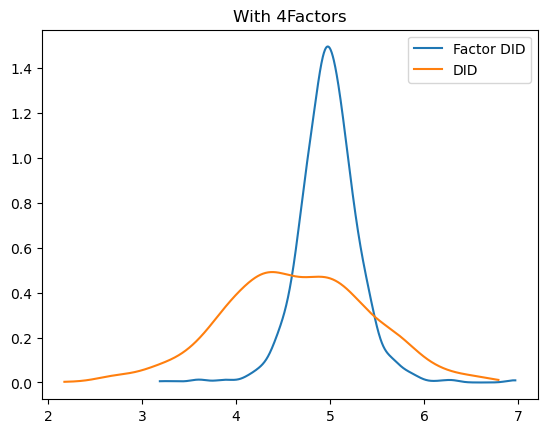

Mean and STD of Factor DID
4.982946211286922 0.3274096787179432
Mean and STD of DID
4.643461179762176 0.7546946186435546


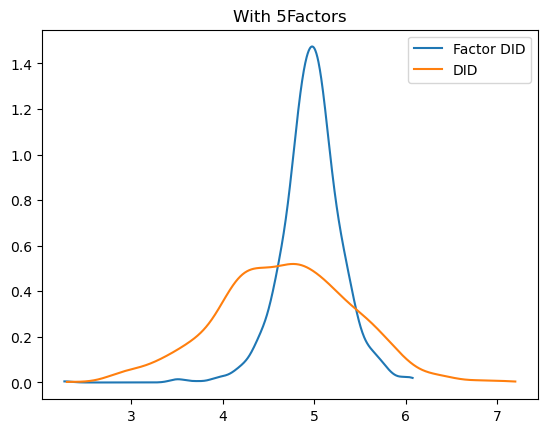

Mean and STD of Factor DID
4.968909565043355 0.33304262820157504
Mean and STD of DID
4.67681113126448 0.7280992045282444


In [22]:
np.random.seed(100)

iter_inner = 20 
S = 1000
N = 200
N0 = 25
T = 20
T0 = 10
nbf = 3
nbfHat =3

Y , X ,C = genData(N = N, T=T, T0=T0, N0 = N0, nbf=nbf, constant = 0 , alphaT=5, alphaC = 1,selection='highValues',correlated_errors=0)

xMatrix = X.reshape(N,T)
yMatrix = Y.reshape(N,T)
treatedUnits = np.where(np.sum(xMatrix,axis=1)>0)[0]
notTreatedUnits = [i for i in  np.arange(xMatrix.shape[0]) if i not in treatedUnits]
colOrder = list(treatedUnits) + notTreatedUnits
yMatrix = yMatrix[colOrder,:]
treatedUnits = np.where(np.sum(xMatrix,axis=1)>0)[0]

for i in np.arange(yMatrix.shape[0]-1,0,-1):
    if i in treatedUnits:
        plt.plot(yMatrix[i,:].T,color='red');
    else: 
        plt.plot(yMatrix[i,:].T,color='grey');
plt.title('Outcomes for each unit - Treated Vs Mean Non Treated, 1 Draw')
plt.show()

meanTreated = np.mean(yMatrix[:len(treatedUnits),:],axis=0)
meanNotTreated = np.mean(yMatrix[len(treatedUnits):,:],axis=0)
plt.plot(meanTreated,color='red');
plt.plot(meanNotTreated,color='grey');
plt.title('Outcomes for each unit - Mean Treated Vs Mean Non Treated, 1 Draw')
plt.show()

# Simulations
for nbfHat in range(1,6):
    res = np.zeros((S,4))
    initL = np.zeros(shape=(N,nbf))
    initF = np.zeros(shape=(T,nbf)) 
    for i in range(nbf):
        initF[i,i] = np.sqrt(T)

    for k in range(S):
        Y , X ,C = genData(N = N, T=T, T0=T0, N0 = N0, nbf=nbf, constant = 0 , alphaT=5, alphaC = 1,selection='highValues',correlated_errors=0)

        D = (np.sum(X.reshape(T,N,order='F'),axis=0)>0).astype(int)
        D = np.kron(D[:,np.newaxis],np.ones((T,1)))
        vecT = np.concatenate((np.zeros((T0-1,1)), np.ones((T - T0+1,1))),axis=0)
        Time = np.kron(np.ones((N,1)),vecT)
        XD = Time*D
        XDC = np.concatenate((XD,C),axis=1)

        betaReg = coefsbai_reg(Y,XDC,nbfHat,initL,initF,iter_inner,1)
        betaDID = simpleDID(Y,XD,C,N,T)

        res[k,0] = betaReg[0]
        res[k,1] = betaReg[1]
        res[k,2] = betaDID[0]
        res[k,3] = betaDID[1]
    
    dsPlot(res[:,0])
    dsPlot(res[:,2])
    plt.legend(['Factor DID','DID']);
    plt.title('With ' + str(nbfHat) + 'Factors')
    plt.show();
    print('Mean and STD of Factor DID')
    print(np.mean(res[:,0]),np.std(res[:,0]))
    print('Mean and STD of DID')
    print(np.mean(res[:,2]),np.std(res[:,2]))
    
    

As we see, and as we expect, the DID gives us biased results. Including more factors in the Factor-DID estimator helps us reduce the bias. It also seems that incresing the number of factors does not change the variance of the estimator.

## Autocorrelation

Lastly, we consider a case where $D$ is defined as before, but this time with autocorrelation present in the errors. We again denote $N=200$ and $T=20$, $D$ is defined as before and:
        $$
        u_{i,t} = \rho u_{i,t-1} + \epsilon_{u,i,t}
        $$

We will proceed to generate data and estimate the parameters as we did in previous cases.


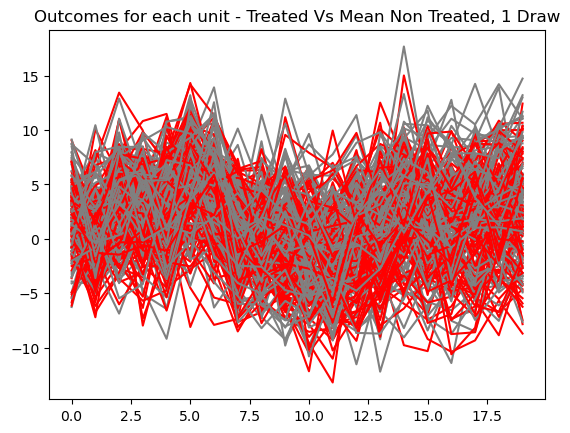

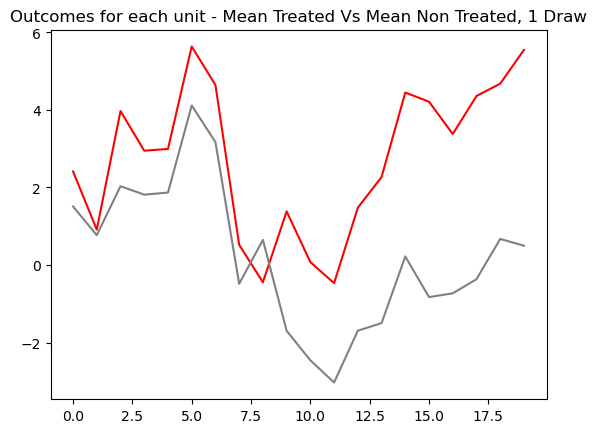

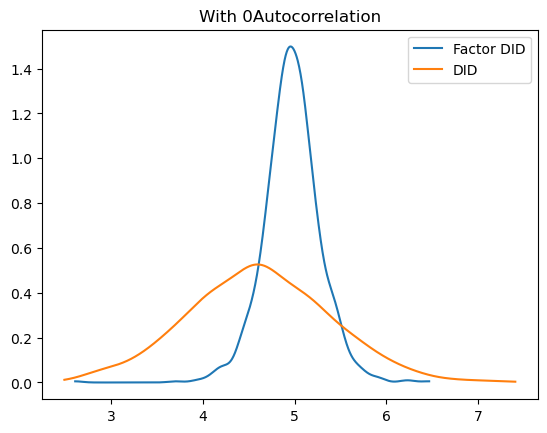

Mean and STD of Factor DID
4.970753199082217 0.31060989109540965
Mean and STD of DID
4.615191260314527 0.7782031255525655


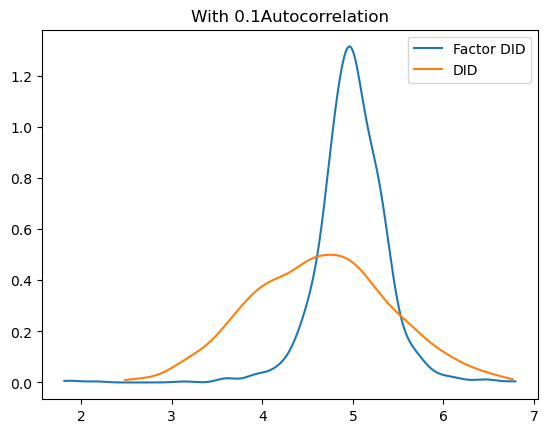

Mean and STD of Factor DID
4.983970560776383 0.3987617687160648
Mean and STD of DID
4.641541499522609 0.7608527265899778


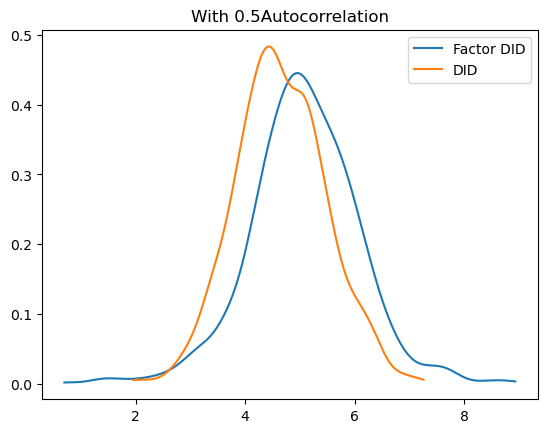

Mean and STD of Factor DID
5.072939821550967 0.9901602378275978
Mean and STD of DID
4.647411311510128 0.8172026807052876


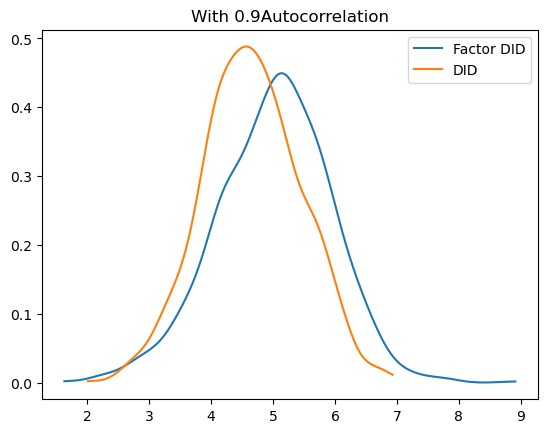

Mean and STD of Factor DID
5.012045122040378 0.9204533793981563
Mean and STD of DID
4.653212428691451 0.7928700291375419


In [23]:
np.random.seed(100)

iter_inner = 20 
S = 1000
N = 200
N0 = 25
T = 20
T0 = 10
nbf = 3
nbfHat =3

Y , X ,C = genData(N = N, T=T, T0=T0, N0 = N0, nbf=nbf, constant = 0 , alphaT=5, alphaC = 3,selection='highValues',correlated_errors=0.9)

xMatrix = X.reshape(N,T)
yMatrix = Y.reshape(N,T)
treatedUnits = np.where(np.sum(xMatrix,axis=1)>0)[0]
notTreatedUnits = [i for i in  np.arange(xMatrix.shape[0]) if i not in treatedUnits]
colOrder = list(treatedUnits) + notTreatedUnits
yMatrix = yMatrix[colOrder,:]
treatedUnits = np.where(np.sum(xMatrix,axis=1)>0)[0]

for i in np.arange(yMatrix.shape[0]-1,0,-1):
    if i in treatedUnits:
        plt.plot(yMatrix[i,:].T,color='red');
    else: 
        plt.plot(yMatrix[i,:].T,color='grey');
plt.title('Outcomes for each unit - Treated Vs Mean Non Treated, 1 Draw')
plt.show()


meanTreated = np.mean(yMatrix[:len(treatedUnits),:],axis=0)
meanNotTreated = np.mean(yMatrix[len(treatedUnits):,:],axis=0)
plt.plot(meanTreated,color='red');
plt.plot(meanNotTreated,color='grey');
plt.title('Outcomes for each unit - Mean Treated Vs Mean Non Treated, 1 Draw')
plt.show()

# Simulations
for rho in [0,0.1,0.5,0.9]:
    res = np.zeros((S,4))
    initL = np.zeros(shape=(N,nbf))
    initF = np.zeros(shape=(T,nbf)) 
    for i in range(nbf):
        initF[i,i] = np.sqrt(T)

    for k in range(S):
        Y , X ,C = genData(N = N, T=T, T0=T0, N0 = N0, nbf=nbf, constant = 0 , alphaT=5, alphaC = 3,selection='highValues',correlated_errors=rho)

        D = (np.sum(X.reshape(T,N,order='F'),axis=0)>0).astype(int)
        D = np.kron(D[:,np.newaxis],np.ones((T,1)))
        vecT = np.concatenate((np.zeros((T0-1,1)), np.ones((T - T0+1,1))),axis=0)
        Time = np.kron(np.ones((N,1)),vecT)
        XD = Time*D
        XDC = np.concatenate((XD,C),axis=1)

        betaReg = coefsbai_reg(Y,XDC,nbfHat,initL,initF,iter_inner,1)
        betaDID = simpleDID(Y,XD,C,N,T)

        res[k,0] = betaReg[0]
        res[k,1] = betaReg[1]
        res[k,2] = betaDID[0]
        res[k,3] = betaDID[1]
    
    dsPlot(res[:,0])
    dsPlot(res[:,2])
    plt.legend(['Factor DID','DID']);
    plt.title('With ' + str(rho) + 'Autocorrelation')
    plt.show();
    print('Mean and STD of Factor DID')
    print(np.mean(res[:,0]),np.std(res[:,0]))
    print('Mean and STD of DID')
    print(np.mean(res[:,2]),np.std(res[:,2]))
    
    

As we can see increasing the autocorrelation in the errors does not affect much the DID estimator, which is still biased and quite noisy, but affects the variance of the Factor-Diff-in-Diff estimator, making it as noisy as the DID estimator. 